# Notebook for Deep Learning Project on DDPMs

This notebook recreates the generative model reported in [this paper](https://arxiv.org/pdf/2006.11239). The Unet employed is a slight modification of the ```ScoreNetwork0``` Unet provided to us. The only modification is the addition of sinusoidal positional embeddings, which helps the model to identify in which part of the diffusion process it is at. The neural network and training loop can be found in the file ```train.py```. 

We set the variance schedule in accordance with the paper:
$$
\beta_{min} = 10^{-4},\quad \beta_{max}=2\cdot 10^{-2},\quad T=1000.
$$

In [25]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
import os
from pathlib import Path

import torch
from torchvision.utils import make_grid, save_image
from train import *

In [45]:
# helper function from week 4 notebook
def show_image(img, save_name=None):
    img = img.detach().cpu()
    with sns.axes_style("white"):
        plt.figure(figsize=(16, 16))
        plt.imshow(img.permute((1, 2, 0)).numpy())
        plt.axis('off')
        if save_name:
            plt.savefig(save_name, dpi=300)
        plt.show()

In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

HOME_PATH = Path(os.getcwd())

print(f"beta_min: {beta_min}, beta_max: {beta_max}, T: {T}")
print(f"device: {device}")
print(f"HOME_PATH: {HOME_PATH}")

beta_min: 0.0001, beta_max: 0.02, T: 1000
device: cuda:0
HOME_PATH: c:\Users\Phill\Documents\School\MSc\2. Sem\Deep Learning\Assignment\TEST


# If loading from pretrained!

In [27]:
LOAD_FROM_PRETRAINED = True

### Choose the dataset

We trained 2 Unets, one on the MNIST dataset and one on the CIFAR 10 dataset. 

In [ ]:
#DATASET = "CIFAR10" 
DATASET = "MNIST"

# initialize model and load weights
score_network = Unet(DATASET).to(device)

ddpm = DDPM(beta_min=beta_min,
            beta_max=beta_max,
            T=T,
            net=score_network,
            device=device,
            dataset=DATASET,
            batchsize=64)



if LOAD_FROM_PRETRAINED:
    model_path = "PRETRAINED/mnist_EPOCH_400.pt" if DATASET == "MNIST" else "PRETRAINED/cifar10_EPOCH_1000.pt"
    ddpm.load_model(model_path)

In [ ]:
train_model = False

if train_model:
    FILE_NAME = f"{DATASET}_DIFFUSION"  # name of the file to save the model
    NUM_EPOCHS = 5                      # number of epochs to train
    SAVE_EVERY = 2                      # save the model every SAVE_EVERY epochs

    !python train.py {DATASET} {NUM_EPOCHS} {FILE_NAME} {SAVE_EVERY}

In [ ]:
if train_model:

    EPOCHS_PATH = FILE_NAME + "/SAMPLES/"
    !python tf_eval.py {DATASET} {EPOCHS_PATH}

In [ ]:
if train_model:
    ddpm.load_model(FILE_NAME + "/" + FILE_NAME + "_final.pt")

Run the below code to sample from noise

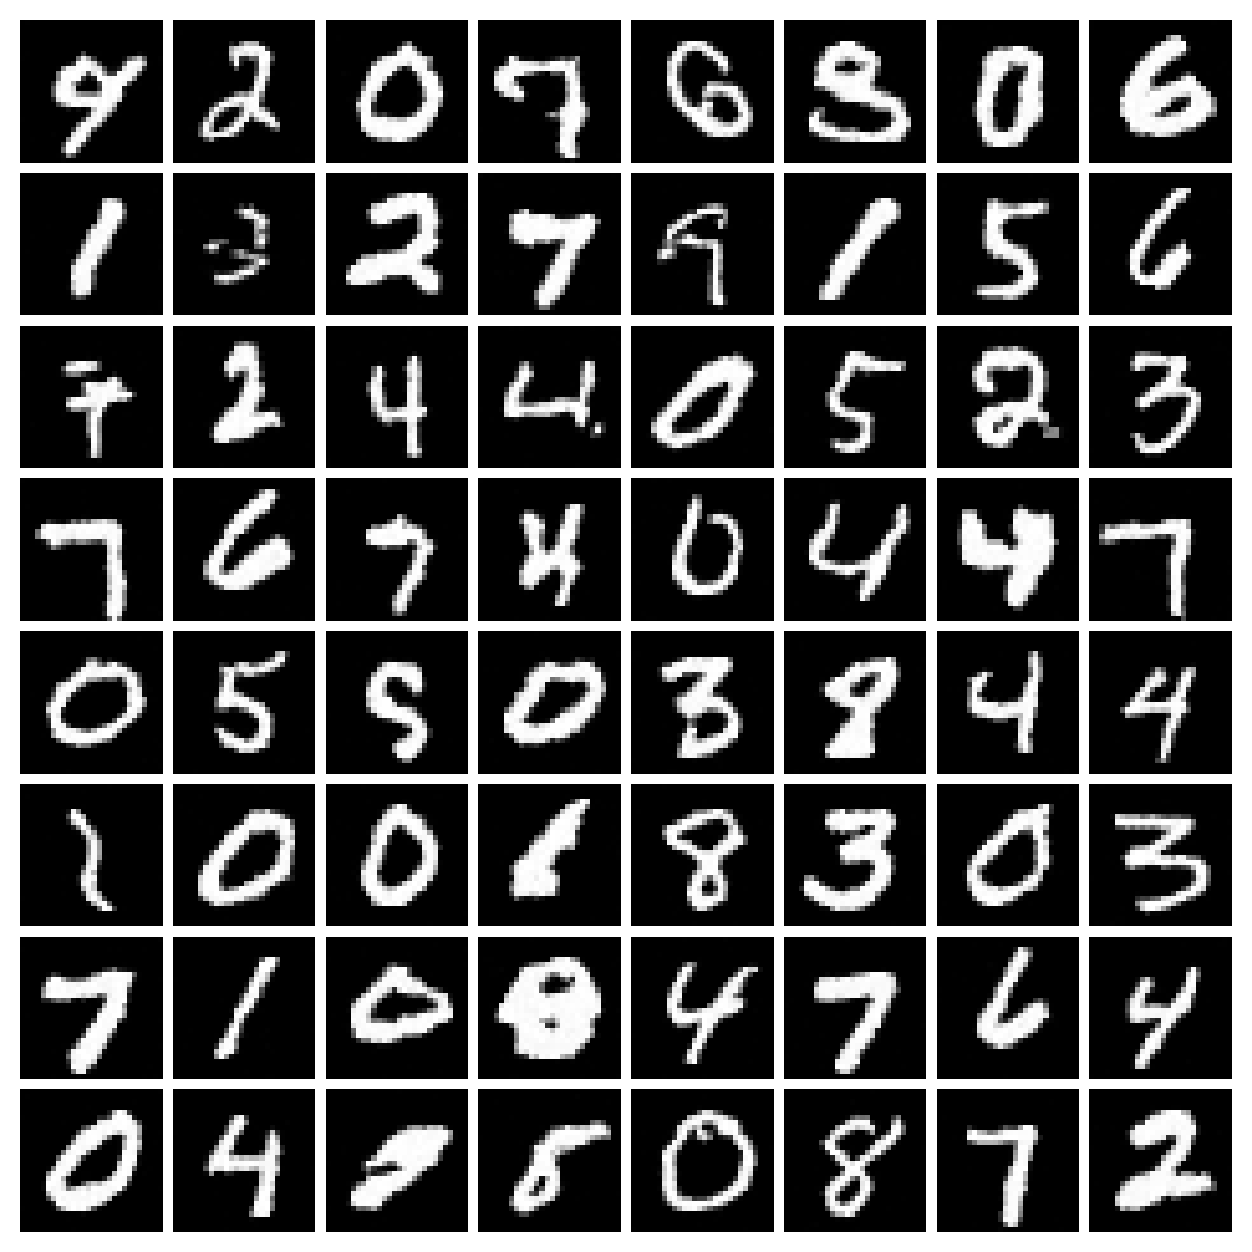

In [33]:
samples = ddpm.sample(num_samples=64)
grid_samples = make_grid(samples, pad_value=1)
save_image(grid_samples, f"{DATASET}_samples.png")
show_image(grid_samples)

## Sample from different epochs:

In [34]:
def sample_inbetween(num_samples, ddpm):
    net = ddpm.net
    device = ddpm.device
    net.eval()
    counter = 0
    with torch.no_grad():
        X = torch.zeros(21, num_samples, *ddpm.data_shape)
        x = torch.randn(num_samples, *ddpm.data_shape).to(device)

        for t in range(T,0,-1):
            if t > 1:
                z = torch.randn_like(x).to(device)
            else:
                z = torch.zeros_like(x).to(device)
        
            output = net(x, torch.tensor([t]*num_samples).to(device))
            
            x = (1/ddpm.alphas[t-1].sqrt() 
                * (x - (1-ddpm.alphas[t-1])/(1-ddpm.alpha_bars[t-1]).sqrt() * output) 
                + ddpm.betas[t-1].sqrt() * z)
            
            if t <501 and t % 25 == 0:      # change these for sampling at different time steps
                X[counter] = torch.clamp((x + 1) * 0.5, 0, 1).detach().cpu()
                counter += 1
    
    X[counter] = torch.clamp((x + 1) * 0.5, 0, 1).detach().cpu()

    return X

In [35]:
inter_samples = sample_inbetween(8, ddpm)

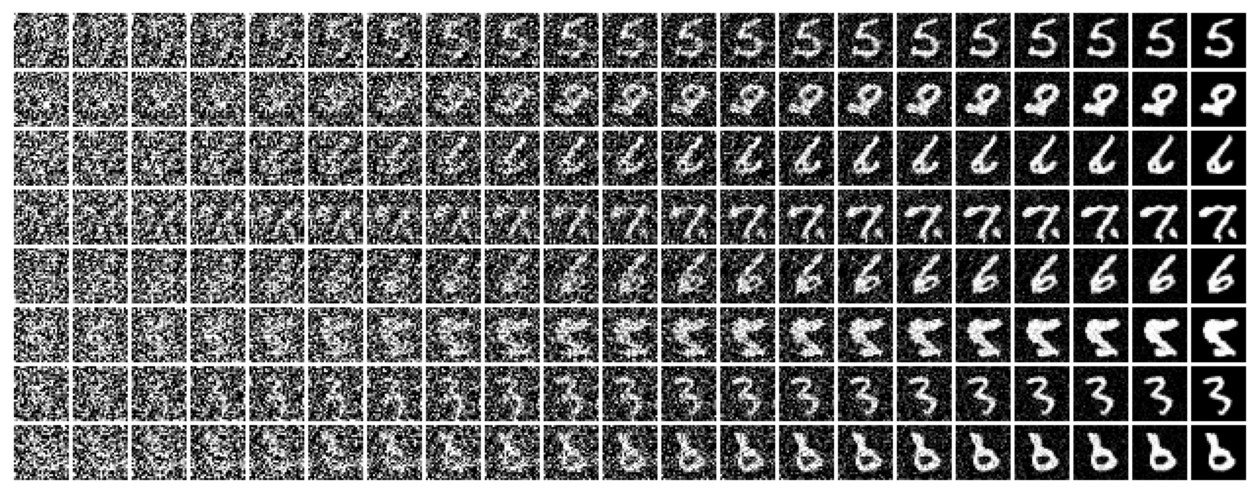

In [36]:
grid_inter_samples = make_grid(inter_samples.permute(1,0,2,3,4).reshape(-1, *ddpm.data_shape), nrow=21, pad_value=1)
save_image(grid_inter_samples, f"{DATASET}_progression.png")
show_image(grid_inter_samples)

# FID scores:

we used the provided code to calculate FID scores. Note that we could only calculate the FID scores for the MNIST samples, as we were not able to find a pretrained CIFAR 10 classifier implemented in tensorflow. It should be noted that ```tensorflow``` 2.15 is required with ```tensorflow-probability``` 0.23 and ```tensorflow-gan```.

## FID scores for MNIST

The scores have been calculated on samples that are not in the github folder, thus the stats are read from a ```.npy``` file.

In [20]:
from tf_eval import *

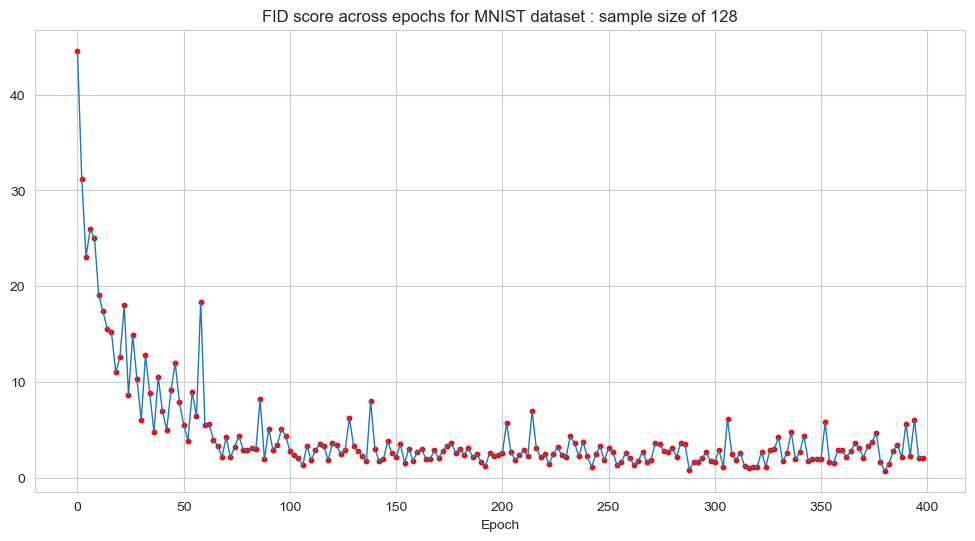

In [37]:
fid_scores = np.load("STATS/fid_scores_mnist.npy") if DATASET == "MNIST" else None

if fid_scores is None:
    print(f"No FID scores available for {DATASET} dataset!!!")
else:
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(np.arange(0, 2*len(fid_scores), 2), fid_scores, linestyle='-', linewidth=1)
    ax.scatter(np.arange(0, 2*len(fid_scores), 2), fid_scores, s=10, c="r")
    ax.set_xlabel("Epoch")
    ax.set_title("FID score across epochs for MNIST dataset : sample size of 128")
    #plt.savefig(f"{DATASET}_fid_scores.png", dpi=300)
    plt.show()

# Prepare a final batch for FID score testing:

prepare 2048 images for the final FID score:

In [43]:
from torchvision.utils import save_image

SAMPLE_FINAL = False    # Set to True to sample 2048 images for final FID score

final_sample_path = f"STATS/{DATASET}_samples/"

if SAMPLE_FINAL:


    if not os.path.exists(final_sample_path):
        os.makedirs(final_sample_path)

    i = 0
    for _ in range(32):
        samples = ddpm.sample(num_samples=64)
        for j in range(samples.shape[0]):
            save_image(samples[j], final_sample_path + f"sample_{i}.png")
            i += 1

In [44]:
if DATASET.lower() == "mnist":
    classifier_fn = mnist_classifier_fn
elif DATASET.lower() == "cifar10":
    raise NotImplementedError("CIFAR10 classifier FID score unavailable")
    classifier_fn = None

activations_real = np.load(f"STATS/ACTIVATIONS/{DATASET.lower()}_activations.npy")
activations_real = tf.convert_to_tensor(activations_real, dtype=tf.float32) 

epoch_dir = Path(final_sample_path)

epoch_images = pack_images_to_tensor(
    path=epoch_dir,
    model=DATASET,
    )
activation_fake = compute_activations(epoch_images, 1, classifier_fn)        
fid = tfgan.eval.frechet_classifier_distance_from_activations(
    activations_real, activation_fake
    )

print(f"Final FID score: {fid}")

0it [00:00, ?it/s]

2048it [00:12, 170.27it/s]


Final FID score: 1.4332467317581177
